In [1]:
"""
ITS8030: Homework 1

Please implement all functions below.

For submission create a project called its8030-2021-hw1 and put the solution in there.

Please note that NumPy arrays and PyTorch tensors share memory represantation, so when converting a
torch.Tensor type to numpy.ndarray, the underlying memory representation is not changed.

There is currently no existing way to support both at the same time. There is an open issue on
PyTorch project on the matter: https://github.com/pytorch/pytorch/issues/22402

There is also a deeper problem in Python with types. The type system is patchy and generics
has not been solved properly. The efforts to support some kind of generics for Numpy are
reflected here: https://github.com/numpy/numpy/issues/7370 and here: https://docs.google.com/document/d/1vpMse4c6DrWH5rq2tQSx3qwP_m_0lyn-Ij4WHqQqRHY
but there is currently no working solution. For Dicts and Lists there is support for generics in the 
typing module, but not for NumPy arrays.
"""
import cv2
import numpy as np
import util
import matplotlib.pyplot as plt
import math

In [2]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['savefig.dpi'] = 300

In [3]:
def load_rgb_img(img_name):
    image_orig = cv2.imread("images/" + img_name, cv2.IMREAD_COLOR)
    return cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
def show_rgb_img(img):
    plt.figure()
    plt.imshow(img)
def load_gray_img(img_name):
    return cv2.imread("images/" + img_name, cv2.IMREAD_GRAYSCALE)
def show_gray_img(img):
    plt.figure()
    plt.imshow(img, cmap="gray")
def save_color_img(image, file_name):
    cv2.imwrite(file_name, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
def save_img(image, file_name):
    cv2.imwrite(file_name, image)

In [4]:
"""
Task 1: Convolution

Implement the function 

convolution(image : np.ndarray, kernel : np.ndarray, kernel_width : int,
            kernel_height : int, add : bool, in_place:bool) -> np.ndarray

to convolve an image with a kernel of size kernel_height*kernel_width.
Use zero-padding around the borders for simplicity (what other options would there be?).
Here:

    image is a 2D matrix of class double
    kernel is a 2D matrix with dimensions kernel_width and kernel_height
    kernel_width and kernel_height are the width and height of the kernel respectively

(Note: in the general case, they are not equal and may not be always odd, so you have to ensure that they are odd.)

    if add is true, then 128 is added to each pixel for the result to get rid of negatives.
    if in_place is True, then the output image should be a copy of the input image. The default is False,
    i.e. the operations are performed on the input image.

Write a general convolution function that can handle all possible cases as mentioned above.
You can get help from the convolution part of the function mean_blur_image (to be implemented in a lab)
to write this function.
"""
def convolution(image : np.ndarray, kernel : np.ndarray, kernel_width : int,
                kernel_height : int, add : bool, in_place : bool = False) -> np.ndarray :
    if kernel_width % 2 == 0 or kernel_height % 2 == 0:
        raise "The function expects the kernel to have odd number of rows and columns"

    # get necessary measurements
    image_width = image.shape[0]
    image_height = image.shape[1]
    kernel_half_width = np.short(np.floor(kernel.shape[0]/2))
    kernel_half_height = np.short(np.floor(kernel.shape[1]/2))

    normalized_kernel = util.normalize_kernel(kernel)
    
    if in_place:
        src_image = image
    else:
        src_image = image.copy()

    # create zeros (for padding) with the correct dimensions (3 for rgb, 2 for bw) 
    if src_image.ndim == 2:
        zeros_lr = np.zeros((kernel_half_width, image_height))
        zeros_tb = np.zeros((image_width + kernel_width - 1, kernel_half_height))
    elif src_image.ndim == 3:
        zeros_lr = np.zeros((kernel_half_width, image_height, 3))
        zeros_tb = np.zeros((image_width + kernel_width - 1, kernel_half_height, 3))

    # add 0 padding from all directions
    src_image = np.append(zeros_lr, src_image, axis=0)
    src_image = np.append(src_image, zeros_lr, axis=0)
    src_image = np.append(zeros_tb, src_image, axis=1)
    src_image = np.append(src_image, zeros_tb, axis=1)

    convolved_img = np.zeros_like(image)
    for m in range(0, image_width):
        for n in range(0, image_height):
            # get part of the image for which the kernel will be applied
            sample_image = src_image[m:m + kernel_width, n:n + kernel_height]

            # apply the kernel
            if src_image.ndim == 2:
                convolved_img[m][n] = np.sum(normalized_kernel * sample_image) + (128 if add else 0)
            elif src_image.ndim == 3:
                convolved_img[m][n][0] = np.sum(normalized_kernel * sample_image[:,:,0]) + (128 if add else 0)
                convolved_img[m][n][1] = np.sum(normalized_kernel * sample_image[:,:,1]) + (128 if add else 0)
                convolved_img[m][n][2] = np.sum(normalized_kernel * sample_image[:,:,2]) + (128 if add else 0)

    return convolved_img

In [5]:
"""
Task 2: Gaussian blur

Implement the function

gaussian_blur_image(image : np.ndarray, sigma : float, in_place : bool) -> np.ndarray 

to Gaussian blur an image. "sigma" is the standard deviation of the Gaussian.
Use the function mean_blur_image as a template, create a 2D Gaussian filter
as the kernel and call the convolution function of Task 1.
Normalize the created kernel using the function normalize_kernel() (to
be implemented in a lab) before convolution. For the Gaussian kernel, use
kernel size = 2*radius + 1 (same as the Mean filter) and radius = int(math.ceil(3 * sigma))
and the proper normalizing constant.

To do: Gaussian blur the image "songfestival.jpg" using this function with a sigma of 4.0,
and save as "task2.png".
"""
def get_gaussian_kernel(sigma : float):
    radius = int(math.ceil(3 * sigma))
    kernel_size = 2 * radius + 1
    return util.gkern(kernel_size, sigma)

def gaussian_blur_image(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray :
    gaus_kernel = get_gaussian_kernel(sigma)    
    return convolution(image, gaus_kernel, gaus_kernel.shape[0], gaus_kernel.shape[1], False, in_place)

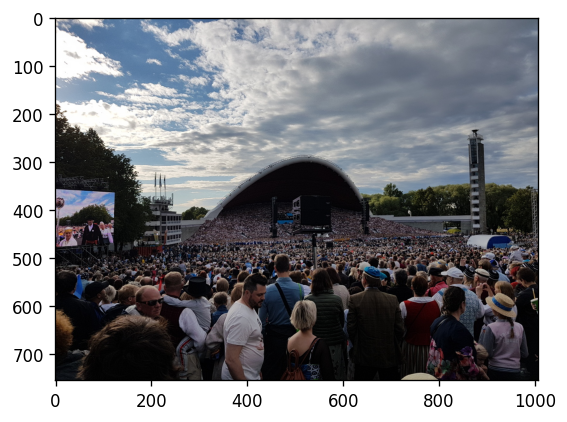

In [6]:
songfestival = load_rgb_img("songfestival.jpg")
show_rgb_img(songfestival)

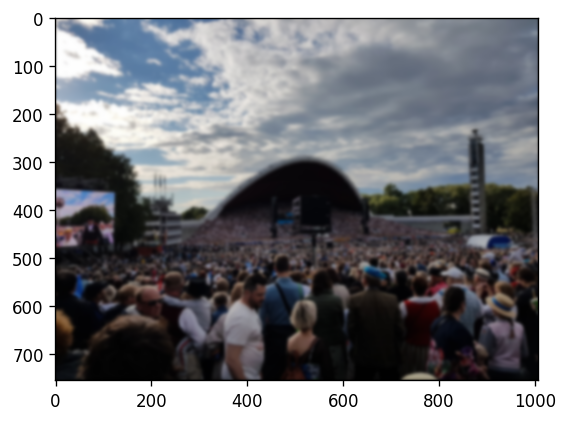

In [7]:
songfestival_blurred = gaussian_blur_image(songfestival, 4.0, False)
show_rgb_img(songfestival_blurred)
save_color_img(songfestival_blurred, './task2.png')

In [8]:
# # black & white img
# image_bw = cv2.imread(img_name, cv2.IMREAD_GRAYSCALE)
# plt.figure()
# plt.imshow(image_bw, cmap="gray")

# songfestival_bw = gaussian_blur_image(image_bw, 4.0, False)
# plt.figure()
# plt.imshow(songfestival_bw, cmap="gray")

In [9]:
"""
Task 3: Separable Gaussian blur

Implement the function

separable_gaussian_blur_image (image : np.ndarray, sigma : float, in_place : bool) -> np.ndarray

to Gaussian blur an image using separate filters. "sigma" is the standard deviation of the Gaussian.
The separable filter should first Gaussian blur the image horizontally, followed by blurring the
image vertically. Call the convolution function twice, first with the horizontal kernel and then with
the vertical kernel. Use the proper normalizing constant while creating the kernel(s) and then
normalize using the given normalize_kernel() function before convolution. The final image should be
identical to that of gaussian_blur_image.

To do: Gaussian blur the image "songfestival.jpg" using this function with a sigma of 4.0, and save as "task3.png".
"""
def separable_gaussian_blur_image (image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray :  
    kernel = util.normalize_kernel(get_gaussian_kernel(sigma))

    kernel_h = kernel[:,[math.floor(kernel.shape[0] / 2)]]
    kernel_w = kernel[[math.floor(kernel.shape[1] / 2)],:]

    blurred_h = convolution(image, kernel_h, kernel_h.shape[0], kernel_h.shape[1], False, in_place)
    blurred_h_w = convolution(blurred_h, kernel_w, kernel_w.shape[0], kernel_w.shape[1], False, in_place)

    return blurred_h_w

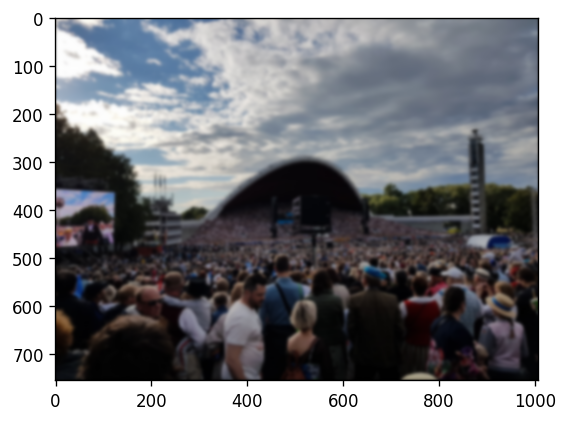

In [10]:
songfestival_separable_blue = separable_gaussian_blur_image(songfestival, 4.0)
show_rgb_img(songfestival_separable_blue)
save_color_img(songfestival_separable_blue, './task3.png')

In [11]:
"""
Task 4: Image derivatives

Implement the functions

first_deriv_image_x(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray
first_deriv_image_y(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray and
second_deriv_image(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray

to find the first and second derivatives of an image and then Gaussian blur the derivative
image by calling the gaussian_blur_image function. "sigma" is the standard deviation of the
Gaussian used for blurring. To compute the first derivatives, first compute the x-derivative
of the image (using the horizontal 1*3 kernel: [-1, 0, 1]) followed by Gaussian blurring the
resultant image.

Then compute the y-derivative of the original image (using the vertical 3*1
kernel: [-1, 0, 1]) followed by Gaussian blurring the resultant image.

The second derivative should be computed by convolving the original image with the
2-D Laplacian of Gaussian (LoG) kernel: [[0, 1, 0], [1, -4, 1], [0, 1, 0]] and then applying
Gaussian Blur.

Note that the kernel values sum to 0 in these cases, so you don't need to
normalize the kernels. Remember to add 128 to the final pixel values in all 3 cases, so you
can see the negative values. Note that the resultant images of the two first derivatives
will be shifted a bit because of the uneven size of the kernels.

To do: Compute the x-derivative, the y-derivative and the second derivative of the image
"cactus.jpg" with a sigma of 1.0 and save the final images as "task4a.png", "task4b.png"
and "task4c.png" respectively.
"""
def first_deriv_image_x(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray :
    x_kernel = np.array([[-1, 0, 1]])
    conv_image = convolution(image, x_kernel, x_kernel.shape[0], x_kernel.shape[1], True, in_place)
    return gaussian_blur_image(conv_image, sigma, in_place)
    
def first_deriv_image_y(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray :
    y_kernel = np.array([[-1], [0], [1]])
    conv_image = convolution(image, y_kernel, y_kernel.shape[0], y_kernel.shape[1], True, in_place)
    return gaussian_blur_image(conv_image, sigma, in_place)

def second_deriv_image(image : np.ndarray, sigma : float, in_place : bool = False) -> np.ndarray :
    laplacian_kernel = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
    conv_image = convolution(image, laplacian_kernel, laplacian_kernel.shape[0], laplacian_kernel.shape[1], True, in_place)
    return gaussian_blur_image(conv_image, sigma, in_place)

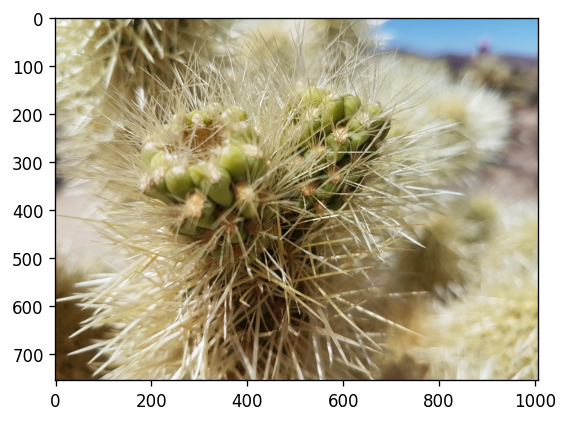

In [12]:
cactus = load_rgb_img("cactus.jpg")
show_rgb_img(cactus)

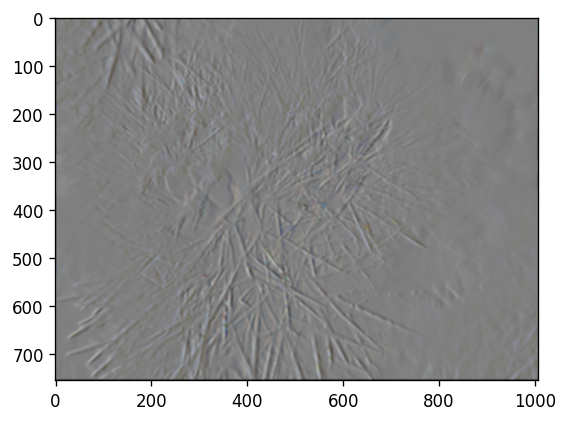

In [13]:
cactus_a = first_deriv_image_x(cactus, 1.0)
show_rgb_img(cactus_a)
save_color_img(cactus_a, './task4a.png')

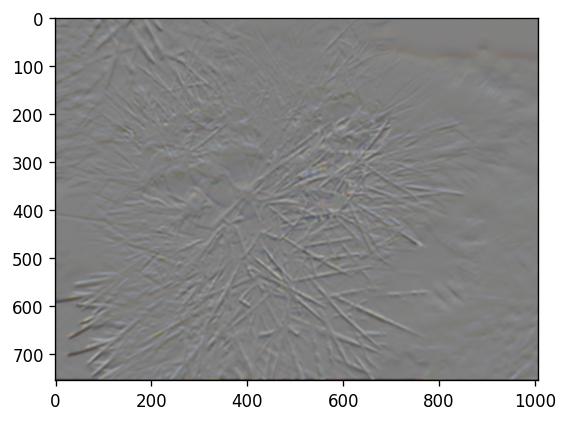

In [14]:
cactus_b = first_deriv_image_y(cactus, 1.0)
show_rgb_img(cactus_b)
save_color_img(cactus_b, './task4b.png')

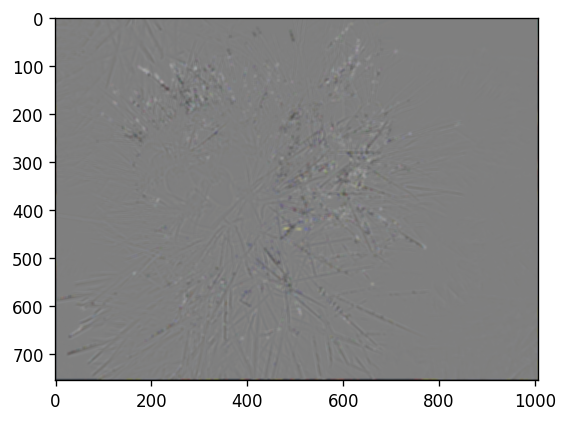

In [15]:
cactus_c = second_deriv_image(cactus, 1.0)
show_rgb_img(cactus_c)
save_color_img(cactus_c, './task4c.png')

In [16]:
"""
Task 5: Image sharpening

Implement the function
sharpen_image(image : np.ndarray, sigma : float, alpha : float, in_place : bool = False) -> np.ndarray
to

sharpen an image by subtracting the Gaussian-smoothed second derivative of an image, multiplied
by the constant "alpha", from the original image.

"sigma" is the Gaussian standard deviation.

Use the second_deriv_image implementation and subtract back off the 128 that second derivative added on.

To do: Sharpen "yosemite.png" with a sigma of 1.0 and alpha of 5.0 and save as "task5.png".
"""
def sharpen_image(image : np.ndarray, sigma : float, alpha : float, in_place : bool = False) -> np.ndarray :
    # convert to grayscale
    img_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sec_deriv = second_deriv_image(img_bw, sigma) - 128.
    result = img_bw - sec_deriv * alpha
    return np.clip(result, 0, 255).astype(np.uint8)

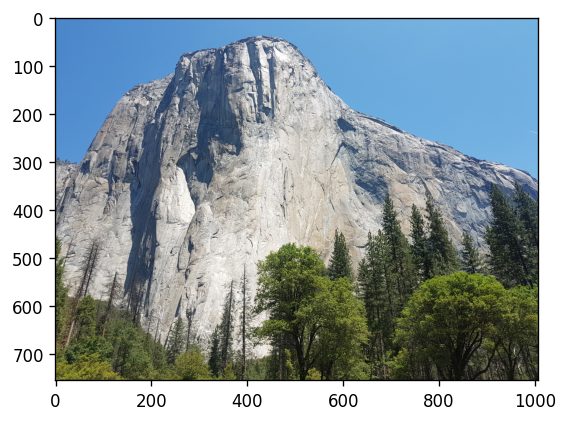

In [17]:
yosemite = load_rgb_img("yosemite.png")
show_rgb_img(yosemite)

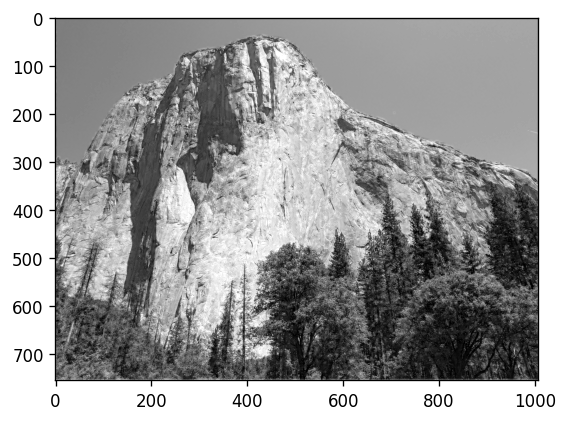

In [18]:
yosemite_sharpened = sharpen_image(yosemite, 1.0, 1.4)
# yosemite_sharpened = np.clip(yosemite_sharpened, 0, 255).astype(np.uint8)
show_gray_img(yosemite_sharpened)
save_img(yosemite_sharpened, 'task5.png')

In [19]:
"""
Task 6: Edge Detection

Implement
sobel_image(image : np.ndarray, in_place : bool = False) -> np.ndarray
to compute edge magnitude and orientation information. Convert the image into grayscale.

Use the standard Sobel masks in X and Y directions:
[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]] and [[1, 2, 1], [0, 0, 0], [-1, -2, -1]] respectively to compute
the edges.

Note that the kernel values sum to 0 in these cases, so you don't need to normalize the
kernels before convolving.

Divide the image gradient values by 8 before computing the magnitude and
orientation in order to avoid spurious edges.

Sobel_image should then display both the magnitude and
orientation of the edges in the image.

To do: Compute Sobel edge magnitude and orientation on "cactus.jpg" and save as "task6.png".
"""
def sobel_image(image : np.ndarray, in_place : bool = False) -> np.ndarray :
    image_float32 = image.astype("float32")
    # convert img to grayscale
    img_bw = cv2.cvtColor(image_float32, cv2.COLOR_RGB2GRAY)
    
    # prepare masks
    x_mask = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    y_mask = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # apply masks to img
    x_sobel = convolution(img_bw, x_mask, x_mask.shape[0], x_mask.shape[1], False, in_place)
    y_sobel = convolution(img_bw, y_mask, y_mask.shape[0], y_mask.shape[1], False, in_place)
    
    # divide by 8 to avoid spurious edges
    x_sobel *= 1./8
    y_sobel *= 1./8

    # calculated using formulas from https://en.wikipedia.org/wiki/Sobel_operator
    magnitude = np.sqrt(x_sobel**2 + y_sobel**2)
    direction = np.arctan2(x_sobel, y_sobel)
#     direction = np.arctan2(y_sobel, x_sobel)
    
    return magnitude, direction

In [20]:
# # example of sobel from wiki on with valve.png
# valve = load_rgb_img("valve.png")
# show_rgb_img(valve)
# magnitude, direction = sobel_image(valve)
# show_gray_img(magnitude)
# show_gray_img(direction)
# valve_diff = magnitude - direction
# show_gray_img(valve_diff)

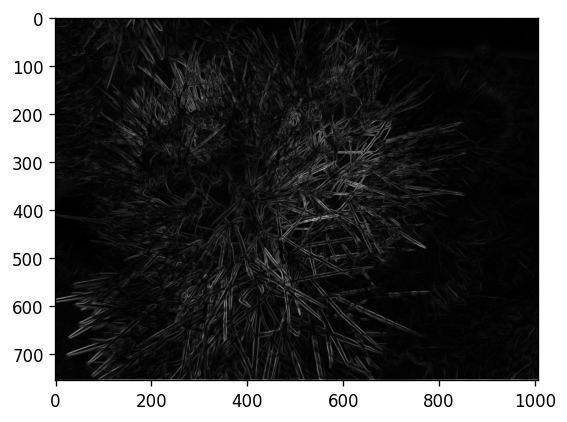

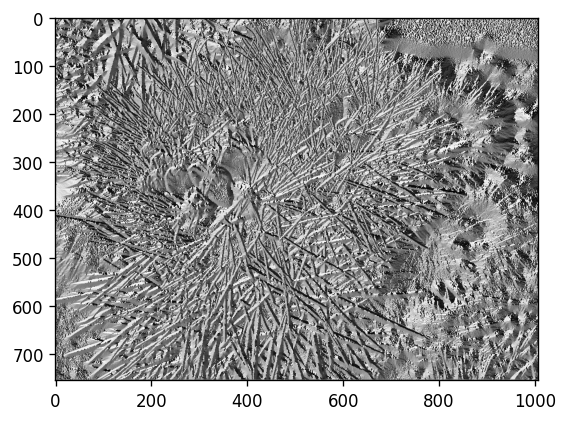

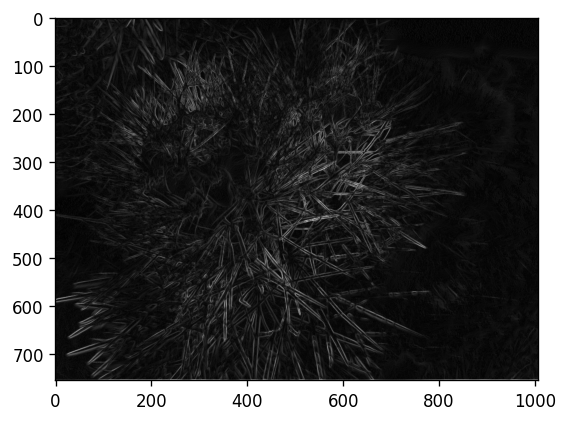

In [21]:
magnitude, direction = sobel_image(cactus)

show_gray_img(magnitude)
show_gray_img(direction)

cactus_sobel = magnitude - direction
show_gray_img(cactus_sobel)
save_img(cactus_sobel, './task6.png')

In [22]:
"""
Task 7: Bilinear Interpolation

Implement the function
bilinear_interpolation(image : np.ndarray, x : float, y : float) -> np.ndarray

to compute the linearly interpolated pixel value at the point (x,y) using bilinear interpolation.
Both x and y are real values. Put the red, green, and blue interpolated results in the vector "rgb".

To do: The function rotate_image will be implemented in a lab and it uses bilinear_interpolation
to rotate an image. Rotate the image "yosemite.png" by 20 degrees and save as "task7.png".
"""
def bilinear_interpolation(image : np.ndarray, x : float, y : float) -> np.ndarray :
    if x < 0 or x > image.shape[1] - 1 or y < 0 or y > image.shape[0] - 1:
        return (0, 0, 0)

    ceil_x = math.ceil(x)
    floor_x = math.floor(x)
    ceil_y = math.ceil(y)
    floor_y = math.floor(y)

    val_00 = image[floor_y][floor_x]
    val_01 = image[floor_y][ceil_x]
    val_10 = image[ceil_y][floor_x]
    val_11 = image[ceil_y][ceil_x]
    
    # formula used from https://en.wikipedia.org/wiki/Bilinear_interpolation#Example
    EQ1 = (ceil_y - y) * val_01 +(y - floor_y) * val_11
    EQ2 = (ceil_y - y) * val_00 + (y - floor_y) * val_10    
    return (ceil_x - x) * EQ1 + (x - floor_x) * EQ2

def rotate_image (image : np.ndarray, rotation_angle : float, in_place : bool = False) -> np.ndarray :
    return util.rotate_image(bilinear_interpolation, image, rotation_angle, in_place)

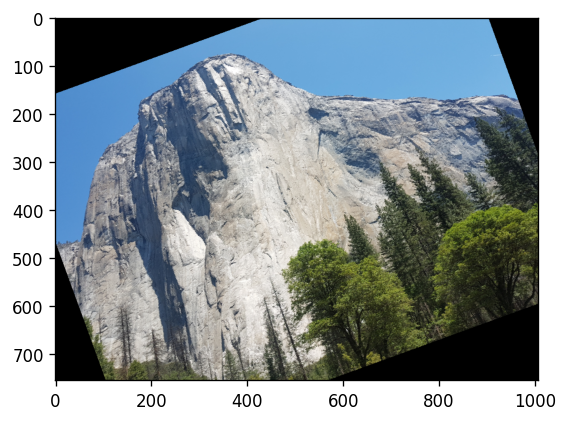

In [23]:
# bilinear_interpolation(yosemite, 20.2, 14.5)
yosemite_rotated = rotate_image(yosemite, 20.0)
show_rgb_img(yosemite_rotated)
save_color_img(yosemite_rotated, './task7.png')

In [24]:
"""
Task 8: Finding edge peaks

Implement the function
find_peaks_image(image : np.ndarray, thres : float, in_place : bool = False) -> np.ndarray
to find the peaks of edge responses perpendicular to the edges.

The edge magnitude and orientation at each pixel are to be computed using the Sobel operators.

1) The original image is again converted into grayscale in the starter code.

A peak response is found by comparing a pixel's edge magnitude to that of the two samples
perpendicular to the edge at a distance of one pixel, which requires the bilinear_interpolation function
(Hint: You need to create an image of magnitude values at each pixel to send as input to the
interpolation function).

If the pixel's edge magnitude is e and those of the other two are e1 and e2, e must be larger than
"thres" (threshold) and also larger than or equal to e1 and e2 for the pixel to be a peak response.

Assign the peak responses a value of 255 and everything else 0. Compute e1 and e2 as follows:
(please check the separate task8.pdf)
To do: Find the peak responses in "virgintrains.jpg" with thres = 40.0 and save as "task8.png".
What would be a better value for thres?
"""
def find_peaks_image(image : np.ndarray, thres : float, in_place : bool = False) -> np.ndarray :
    magnitude, direction = sobel_image(image)
    
    result_img = np.zeros_like(image)
    for c in range(0, image.shape[0]):
        for r in range(0, image.shape[1]):
            # theta param and its computation used from provided pdf
            param = direction[c][r]
            if math.isnan(param):
                param = 0

            e1x = c + 1 * np.cos(param)
            e1y = r + 1 * np.sin(param)
            e2x = c - 1 * np.cos(param)
            e2y = r - 1 * np.sin(param)
            # coordinates need to be checked before interpolation
            e1 = 0 if e1x < 0 or e1x > magnitude.shape[1] - 1 or e1y < 0 or e1y > magnitude.shape[0] - 1 else bilinear_interpolation(magnitude, e1x, e1y)
            e2 = 0 if e2x < 0 or e2x > magnitude.shape[1] - 1 or e2y < 0 or e2y > magnitude.shape[0] - 1 else bilinear_interpolation(magnitude, e2x, e2y)

            e = magnitude[c][r]
            if e > thres and e > e1 and e > e2:
                result_img[c][r] = 255.

    return result_img

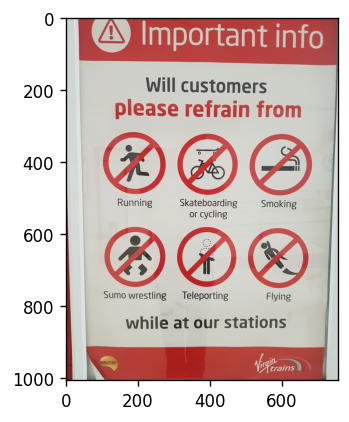

In [25]:
virgintrains = load_rgb_img("virgintrains.jpg")
show_rgb_img(virgintrains)

In [26]:
virgintrains = virgintrains.astype("float32")
virgintrains_peaks = find_peaks_image(virgintrains, 40.0)

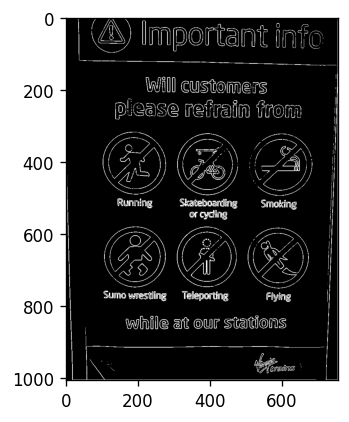

In [27]:
virgintrains_peaks_clipped = np.clip(virgintrains_peaks, 0, 255).astype(np.uint8)
show_gray_img(virgintrains_peaks_clipped)
save_img(virgintrains_peaks_clipped, './task8.png')

In [28]:
"""
Task 9 (a): K-means color clustering with random seeds (extra task)

Implement the function

random_seed_image(image : np.ndarray, num_clusters : int, in_place : bool = False) -> np.ndarray

to perform K-Means Clustering on a color image with randomly selected initial cluster centers
in the RGB color space. "num_clusters" is the number of clusters into which the pixel values
in the image are to be clustered. Use random.randint(0,255) to initialize each R, G and B value.
to create #num_clusters centers, assign each pixel of the image to its closest cluster center
and then update the cluster centers with the average of the RGB values of the pixels belonging
to that cluster until convergence. Use max iteration # = 100 and L1 distance between pixels,
i.e. dist = |Red1 - Red2| + |Green1 - Green2| + |Blue1 - Blue2|. The algorithm converges when
the sum of the L1 distances between the new cluster centers and the previous cluster centers
is less than epsilon*num_clusters. Choose epsilon = 30 (or anything suitable). Note: Your code
should account for the case when a cluster contains 0 pixels during an iteration. Also, since
this algorithm is random, you will get different resultant images every time you call the function.

To do: Perform random seeds clustering on "flowers.png" with num_clusters = 4 and save as "task9a.png".
"""
def random_seed_image(image : np.ndarray, num_clusters : int, in_place : bool = False) -> np.ndarray :
    "implement the function here"
    raise "not implemented yet!"

In [29]:
"""
Task 9 (b): K-means color clustering with pixel seeds (extra)

Implement the function
pixel_seed_image(image : np.ndarray, num_clusters: int, in_place : bool = False)
to perform K-Means Clustering on a color image with initial cluster centers sampled from the
image itself in the RGB color space. "num_clusters" is the number of clusters into which the
pixel values in the image are to be clustered. Choose a pixel and make its RGB values a seed
if it is sufficiently different (dist(L1) >= 100) from already-selected seeds. Repeat till
you get #num_clusters different seeds. Use max iteration # = 100 and L1 distance between pixels,
 i.e. dist = |Red1 - Red2| + |Green1 - Green2| + |Blue1 - Blue2|. The algorithm converges when
 the sum of the L1 distances between the new cluster centers and the previous cluster centers
is less than epsilon*num_clusters. Choose epsilon = 30.

To do: Perform pixel seeds clustering on "flowers.png" with num_clusters = 5 and save as "task9b.png".
"""
def pixel_seed_image(image : np.ndarray, num_clusters: int, in_place : bool = False) -> np.ndarray :
    "implement the function here"
    raise "not implemented yet!"